## Tutorial of DICNAP to simulated data

Our simulation consider total nine metylation intensity function patterns of age:non-correlation (NC), linear increase (LI), linear decrease (LD), and six types of non-linear pattern (NLI40:increase from age 40, NLD40:decrease from age 40, NLI60:increase from age 60, NLD60:decrease from age 60, NLI80:increase from age 80, NLD80:decrease from age 80). We generated methylation data for 300 people x 1800 sites. The 1800 methylation sites consisted of 200 each of NC, LI, LD, NLI40, NLD40, NLI60, NLD60, NLI80, NLD80. 
simu_data.RData contains three objects: 'methy_data', 'person_ages' and 'true_lab'. methy_data is the methylation intensity matrix of 300 persons by 1800 sutes. person_ages is the age of the persons and. true_lab is the true group labels of each site.


In [1]:
##load data
load("simu_data.RData")
ls()

[1] "methy_data"  "person_ages" "true_lab"

In [2]:
head(methy_data)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,⋯,site1791,site1792,site1793,site1794,site1795,site1796,site1797,site1798,site1799,site1800
person1,0.3048231,0.2935850,0.4276659,0.04193405,0.7737434,0.737477283,0.10489887,0.05892439,0.45450645,0.81318735,⋯,0.8600610,0.5886411,0.9382160,0.9769965,0.9140718,0.9519023,0.9774713,0.5697757,0.5803213,0.6735991
person2,0.8364729,0.6216839,0.1354503,0.87332896,0.6441271,0.227646022,0.92046259,0.22030937,0.06112123,0.76176394,⋯,0.6777448,0.9869997,0.9872591,0.9454766,0.9854080,0.7011803,0.7759430,0.9902684,0.9694296,0.9840308
person3,0.5891011,0.5299404,0.5807231,0.01327347,0.8534798,0.270476786,0.77830675,0.36699837,0.56012477,0.75122742,⋯,0.9567057,0.9865753,0.9953139,0.8829258,0.9502494,0.9984057,0.9610239,0.8561309,0.9823431,0.9125144
person4,0.7443480,0.2836927,0.1308176,0.46962438,0.6256304,0.336726685,0.83823772,0.79090804,0.26971394,0.40415906,⋯,0.7605094,0.9058688,0.9769699,0.7300858,0.8952578,0.9195067,0.8987146,0.8800636,0.8899089,0.8428989
person5,0.4579622,0.2601650,0.8309014,0.23835309,0.5417238,0.004382176,0.51909744,0.53779469,0.55131263,0.69237487,⋯,0.9506289,0.9973099,0.9914835,0.9827966,0.9529789,0.9624868,0.9757098,0.9911413,0.8455371,0.6993660
person6,0.7285580,0.1089360,0.7020370,0.43505295,0.8768726,0.000539727,0.06824782,0.88295715,0.68494124,0.03608803,⋯,0.8225377,0.7770141,0.9282404,0.9352871,0.8317756,0.9996755,0.6097677,0.9399357,0.9267365,0.9661261


In [3]:
length(person_ages)
length(true_lab)

[1] 300

[1] 1800

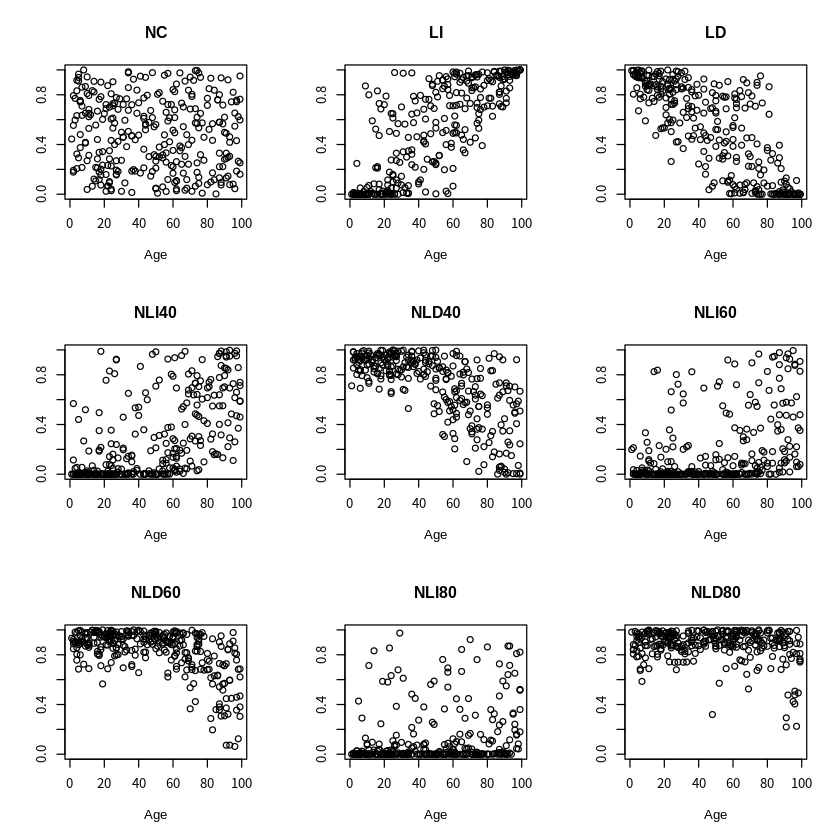

In [4]:
#Data Example of each pattern
sample_idx <- c(1, 201, 401, 601, 801, 1001, 1201, 1401, 1601)
labs <- c("NC", "LI","LD", "NLI40", "NLD40","NLI60", "NLD60","NLI80", "NLD80")
par(mfrow=c(3,3))
for(i in 1:length(sample_idx)){
    met_int <- methy_data[,sample_idx[i]]
    plot(person_ages, met_int, ylim=c(0,1), xlim=c(1,99), xlab="Age", ylab="", main=labs[i])
}


In [5]:
## Apply DICNAP

In [6]:
# Raed library
library(minerva)
library(fdapace)
library(ClusterR)
library(pheatmap)
library(data.table)

Loading required package: gtools



In [7]:
#STEP1: MIC calculation
const <- 10^5
region_num <- ncol(methy_data)
mic <- rep(NA,region_num)
cors<- rep(NA,region_num)
micr2 <- rep(NA,region_num)
mic_r <- rep(NA,region_num)
for(i in 1:region_num){
      vec <- const * as.numeric(methy_data[,i])

      #Mine
      res <- mine(person_ages, vec, na.rm=T)
      mic[i] <- res$MIC
      micr2[i] <- res$"MIC-R2"
      cors[i] <- cor(person_ages, vec)

     
      person_ages_r <- sample(person_ages)
      res <- mine(person_ages_r, vec, na.rm=T)
      mic_r[i] <- res$MIC
}

#MIC pvals
mic_pval <- rep(NA,region_num)
for(i in 1:region_num){
    mic_pval[i] <- sum(mic_r >= mic[i])/region_num
}
mic_rec <- as.data.frame(cbind(mic, cors, micr2, mic_r, mic_pval))
rownames(mic_rec) <- colnames(methy_data)


#Workflow
cpg_cat <- rep("empty", ncol(methy_data))
names(cpg_cat) <- colnames(methy_data)


#Filter NC sites
mt <- "BH"
mic_adp <- p.adjust(mic_rec$mic_pval, method=mt)
idx <- which(mic_adp < 0.05)
methy_data_ass <- methy_data[,idx]
mic_rec_ass <- mic_rec[idx,]
cpg_cat[colnames(methy_data[,-idx])] <- "NC"

In [8]:
#Filter LI and LD sites
l_idx <- which(mic_rec_ass$micr2 < 0.05)
methy_data_nl <- methy_data_ass[,-l_idx]
mic_rec_nl <- mic_rec_ass[-l_idx,]
methy_data_li <- methy_data_ass[,l_idx]
mic_rec_li <- mic_rec_ass[l_idx,]
cpg_cat[colnames(methy_data_li[,mic_rec_li$cors>=0])] <- "LI"
cpg_cat[colnames(methy_data_li[,mic_rec_li$cors<0])] <- "LD"

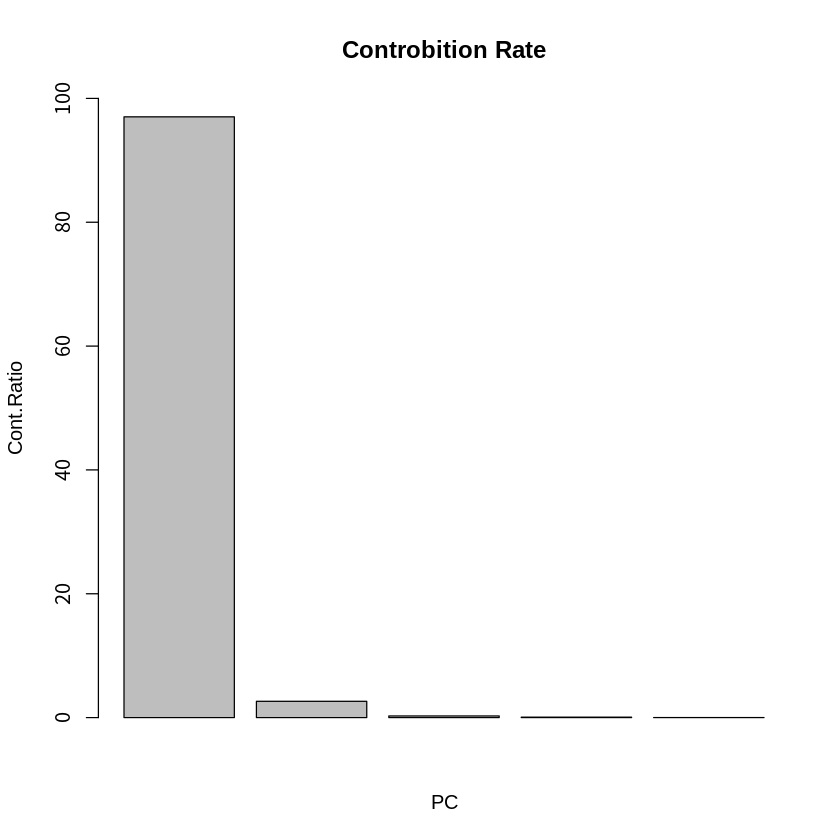

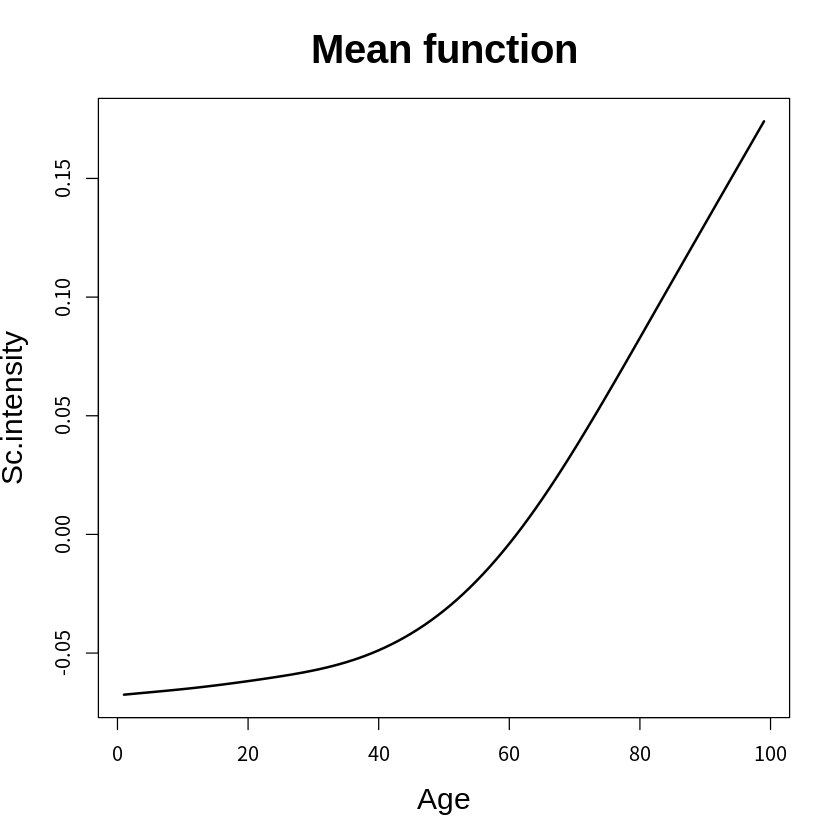

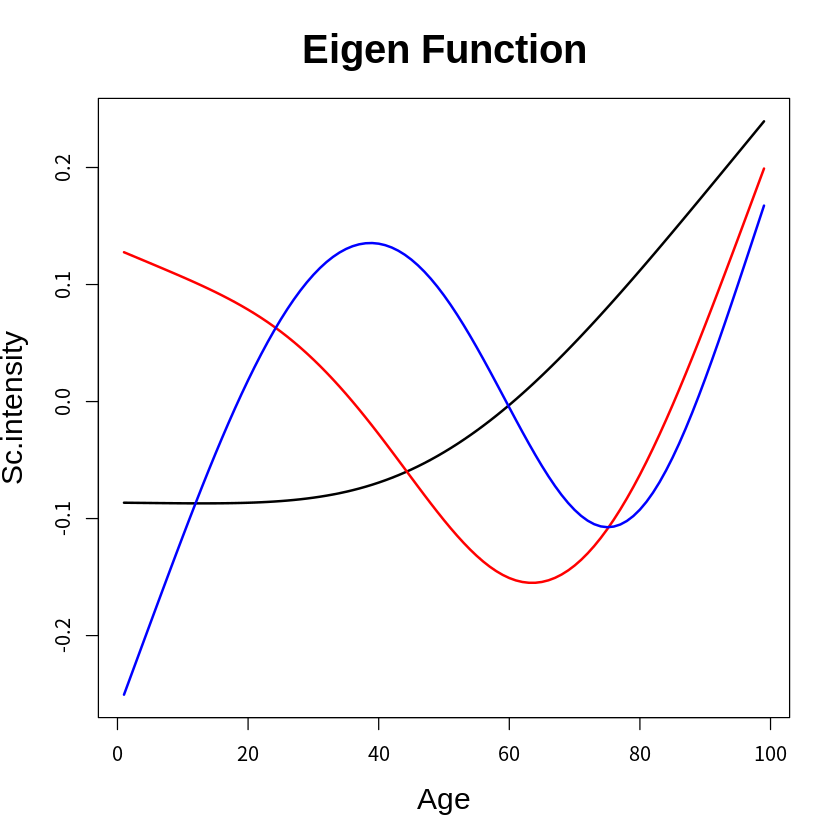

In [9]:
#Analysis for non linear sites
mdat_cor <- scale(methy_data_nl)
ages_grid <- min(person_ages):max(person_ages)
n_sites <- ncol(mdat_cor) #sites after STEP1 filtering
n_ages_grid <- length(ages_grid)

#smoothing spline
methyl_mat_smooth <- matrix(0, n_sites, n_ages_grid)
rownames(methyl_mat_smooth) <- colnames(mdat_cor)
for(i in 1:n_sites){
    vec_raw <- as.numeric(mdat_cor[,i])
    model <- smooth.spline(person_ages, vec_raw, all.knots=T, df=4)
    pred <- predict(model, ages_grid)$y
    methyl_mat_smooth[i,] <- pred
}

#FPCA 
ID <- rep(1:n_sites, each=n_ages_grid)
Days <- as.numeric(rep(ages_grid, n_sites))
nEggs <- as.numeric(t( methyl_mat_smooth))
dat_fpca <- data.frame(ID, Days, nEggs)
Flies <- MakeFPCAInputs(dat_fpca$ID, dat_fpca$Days, dat_fpca$nEggs,deduplicate=TRUE)
fpcaObjFlies <- FPCA(Flies$Ly, Flies$Lt,optns=list(FVEthreshold=1, useBinnedData="OFF"))
pc_full = fpcaObjFlies$xiEst
rownames(pc_full) <- rownames(methyl_mat_smooth)
eigfuncs = fpcaObjFlies$phi
mufunc = fpcaObjFlies$mu
x_grid = fpcaObjFlies$workGrid
eigs <- fpcaObjFlies$lambda


#Controbution rate plot
eigs_top5 <- (eigs*100/sum(eigs))[1:5]
barplot(eigs_top5, ylim=c(0,100), xlab="PC", ylab="Cont.Ratio", main="Controbition Rate")

#Mean and Eigenfunction
col_pat <- c("black","red", "blue", "purple", "cyan", "magenta", "grey", "brown", "yellow")
matplot(x_grid, mufunc, xlab="Age", ylab="Sc.intensity",cex.lab=1.5, type="l", lwd=2, main="Mean function", cex.main=2)
matplot(x_grid, eigfuncs[,1:3], xlab="Age", ylab="Sc.intensity",type="l", col=col_pat[1:3], lwd=2, lty=1, main="Eigen Function", cex.lab=1.5, cex.main=2)

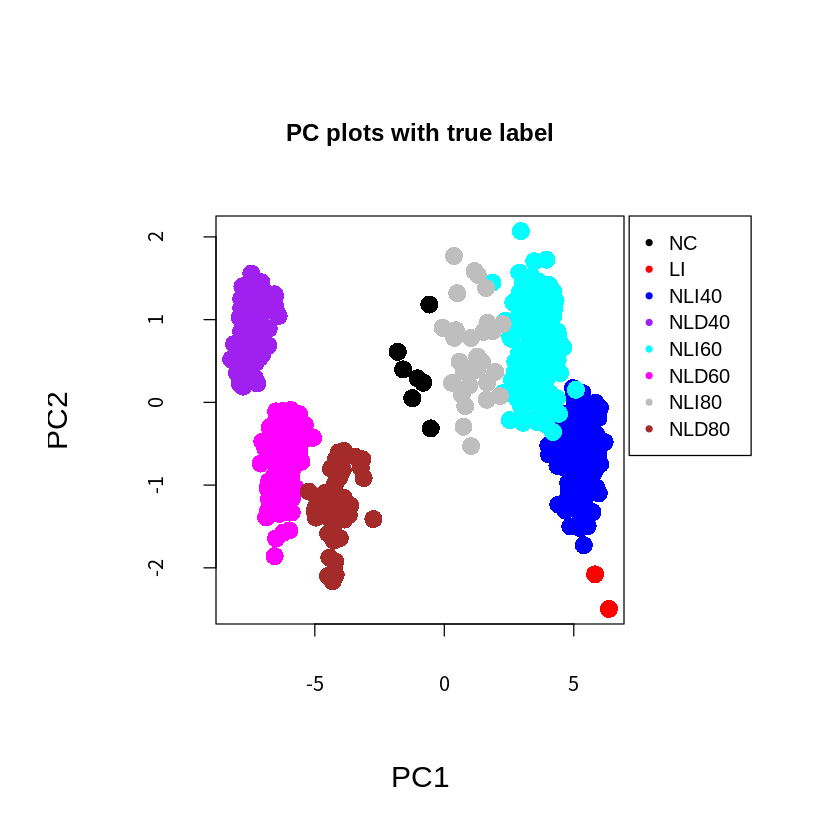

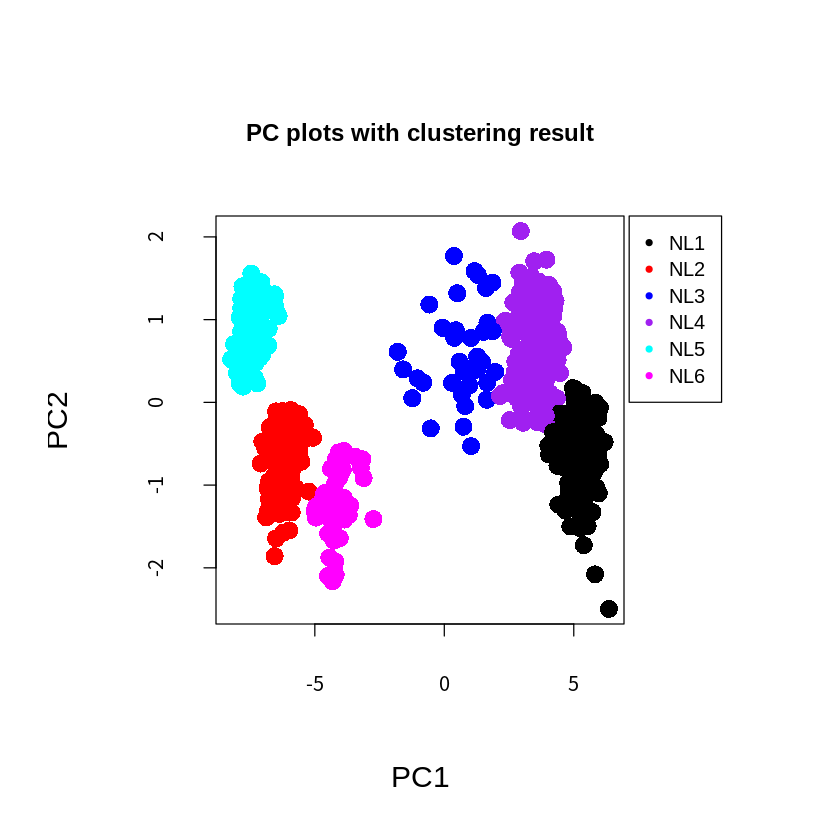

In [10]:
#automatic cluster detection
sig_jiku <- max(which((eigs/sum(eigs))>0.01))
pc_used <- pc_full
opt <- Optimal_Clusters_KMeans(pc_used, max_clusters = 10, plot_clusters = F, criterion = 'distortion_fK', fK_threshold = 0.85, initializer = 'optimal_init', tol_optimal_init = 0.2)
n_cls <- max(which(opt < 0.85))
km_rc <- KMeans_rcpp(pc_used, clusters = n_cls, num_init = 5, max_iters = 100, initializer = 'optimal_init', verbose = F)
cls <- km_rc$clusters

##PC plot with the true group label
labs2 <- true_lab[rownames(pc_used)]
unq_lab <- unique(labs2)
col_vec <- rep(NA, nrow(pc_used))
for(i in 1:length(unq_lab)){
  col_vec[labs2==unq_lab[i]] <- col_pat[i]
}
par(mar=c(7,7, 7,7)) #bot, left, top, roght
par(oma=c(2,2,2,2))
par(mgp=c(6,2,0))
plot(pc_used[,1], pc_used[,2], col=col_vec, xlab="PC1", ylab="PC2",cex.lab=1.5, cex=2, pch=16, main="PC plots with true label")
par(xpd=T)
legend(par()$usr[2] + 0.2, par()$usr[4], legend=unq_lab, pch=20, col=col_pat[1:length(unq_lab)])

  
#PC plot with the identified NL groups
set.seed(1000)
k_best <- length(unique(cls))
col_vec <- rep(NA, nrow(pc_used))
for(i in 1:k_best){
    col_vec[cls==i] <- col_pat[i]
}
par(mar=c(7,7, 7,7)) #bot, left, top, roght
par(oma=c(2,2,2,2))
par(mgp=c(6,2,0))
plot(pc_used[,1], pc_used[,2], col=col_vec, xlab="PC1", ylab="PC2",cex.lab=1.5, cex=2, pch=16,main="PC plots with clustering result")
par(xpd=T)
legend(par()$usr[2] + 0.2, par()$usr[4], legend=paste0("NL",1:k_best), pch=20, col=col_pat[1:k_best])

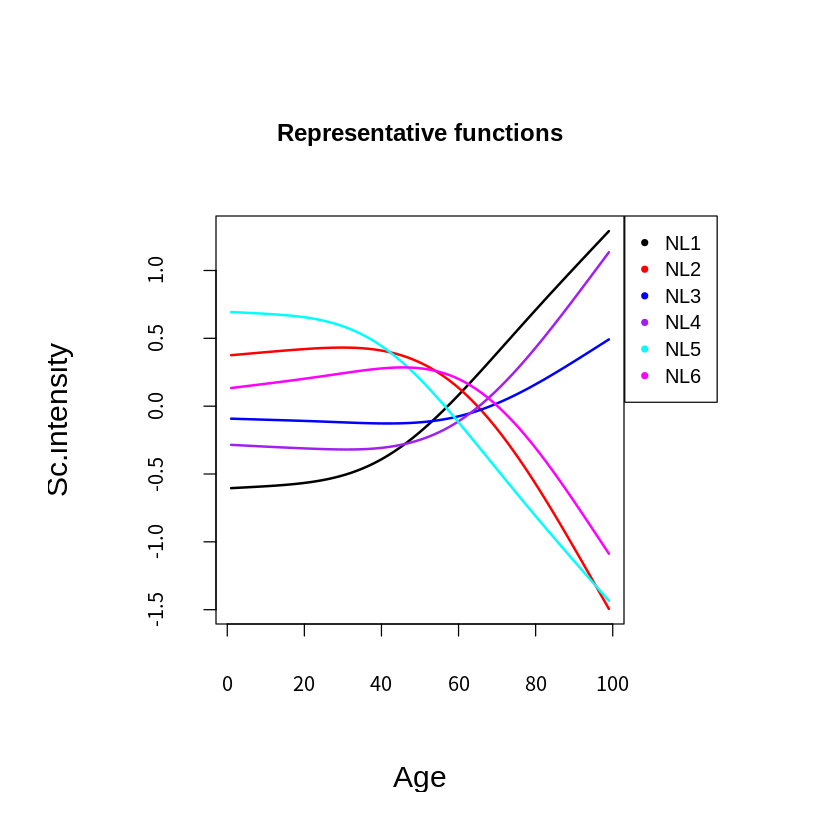

In [11]:
##Draw the representative functions
n_ages_grid <- length(x_grid)
rep_mat <- matrix(NA, n_ages_grid, k_best)
med_mat <- NULL
for(k in 1:k_best){
    pc_cls <- pc_used[cls==k, 1:sig_jiku]
    cpg_cat[rownames(pc_cls)] <- paste0("NL", k)
    pc_median <- apply(pc_cls, 2, median)
    repre_pat <- mufunc
    for(i in 1:ncol(pc_cls)){
        repre_pat <- repre_pat + pc_median[i] * eigfuncs[,i]
    }
    main_text <- paste0("NL",k)
    rep_mat[,k] <- repre_pat
}
par(mar=c(7,7, 7,7)) #bot, left, top, roght
par(oma=c(2,2,2,2))
par(mgp=c(6,2,0))
matplot(x_grid, rep_mat, col=col_pat[1:k_best], xlab="Age", ylab="Sc.intensity", type="l",cex.lab=1.5, lwd=2, lty=1, main="Representative functions")
par(xpd=T)
legend(par()$usr[2] + 0.2, par()$usr[4], legend=paste0("NL",1:k_best), pch=20, col=col_pat[1:k_best])

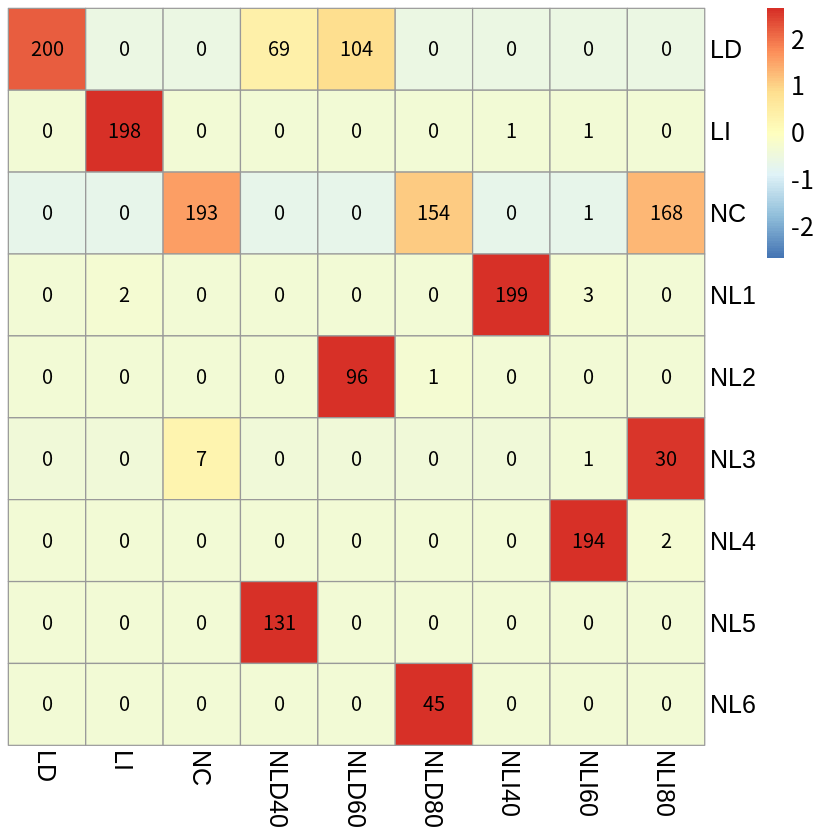

In [12]:
#Confusion matrix
mat <- table(cpg_cat, true_lab)
pheatmap(mat, cluster_row = FALSE, cluster_col = FALSE, scale="row", display_numbers = mat, number_color = "black", fontsize = 15)